# Initialize

To use:
    1. Adjust the mix variable for each data set
    2. Drag and drop all of the data that is to be fit and analyzed.
        a) the program auto deletes all unnessary files (.SPE, .dat, .log)
        b) for days with multiple sets of conditions run, only drag and drop one data for one set of conditions at a time (easiest method). There are also optional lines in the 'Analysis' section that can be used to select 'Runs # through #'

In [1]:
import os, sys
import numpy as np
import scipy as sp
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from IPython.display import display
import xlwt, xlrd
from pylab import*

print(os.getcwd()) # Double check that data is in this folder

/Users/kzuraski/Desktop/0521


# Variables

In [2]:
mix = .3759 # Adjust the mix ratio here

plot_col = 2
#time_step = 50 #time step in between each data point in micro seconds (us)
time_idx_st = 5
time_idx_en = 900

# cent_WL = 450 #Centre wavelength of the CCD, in nm
# WL_cal = 0.103 #nm per pixel
# WL_int = cent_WL - 69.57 #nm offset
# CCD_size = 1340 #CCD total pixel count 

# Eliminate Unnecessary Files

In [3]:
for item in os.listdir(os.getcwd()):
    if item.endswith(".SPE") or item.endswith(".log") or item.endswith(".dat"):
        if not item.endswith("average.log"):
            if not item.endswith("FINAL.dat"):
                os.remove(os.path.join(os.getcwd(),item))     

# Import CCD data and average

In [4]:
# filelist = []
# avg_arr = []
# temp_arr = []
# cur_Par = 0
# WL_arr = []

# file_suff = "ICCD_" #File suffix - change here
# summ_file_base = "AVG_CCD_" #Output file base
# summ_file_ext = ".txt" #Output file extension

# #Create WL array
# func1 = lambda i, j: i*WL_cal+WL_int
# WL_arr = np.fromfunction(np.vectorize(func1), (CCD_size,1),  dtype=int)
# WL_arr = WL_arr.flatten()

# #find all files with "ICCD_" start
# for file in os.listdir(os.getcwd()):
#     if file.startswith(file_suff):
#         filelist = np.append(filelist, str(file))
    
# for idx, item in enumerate(filelist):
#     #split file name "ICCD_a_b.txt" by "_" character. a and b are used to average multiple files. 
#     #tsh is "trash" variable (i.e. not needed)
#     tsh, a, b = item.split("_")
#     b, tsh = b.split(".")
#     a = int(a)
#     b = int(b)
    
#     if cur_Par == 0: #current parent filename
#         cur_Par = a  
#         data_arr = np.genfromtxt(item, delimiter = '\t', usecols=(1), dtype = 'str')

#     elif cur_Par == a: #continue adding data to array
#         temp_arr = np.genfromtxt(item, delimiter = '\t', usecols=(1), dtype = 'str')
#         data_arr = np.vstack((data_arr,temp_arr))

#     elif cur_Par !=a: #end this data collection, calc mean, write file and start new array.
#         if data_arr.ndim == 1:
#             avg_arr = data_arr
        
#         else :
#             avg_arr = np.mean(data_arr.astype(np.float),axis=0)

#         avg_arr = np.vstack((WL_arr,avg_arr))
#         save_file = open(summ_file_base+str(cur_Par)+summ_file_ext, 'wb')
#         np.savetxt(save_file, np.transpose(avg_arr), delimiter = '\t',fmt="%s")
#         save_file.close()
#         data_arr = np.genfromtxt(item, delimiter = '\t', usecols=(1), dtype = 'str')
#         cur_Par = a

# #average and save anything that is left after the loop.
# if data_arr.ndim == 1:
#     avg_arr = data_arr
# else :
#     avg_arr = np.mean(data_arr.astype(np.float),axis=0)

# avg_arr = np.vstack((WL_arr,avg_arr))
# save_file = open(summ_file_base+str(a)+summ_file_ext, 'wb')
# np.savetxt(save_file, np.transpose(avg_arr), delimiter = '\t',fmt="%s")
# save_file.close()

# # Delete extra files
# for item in os.listdir(os.getcwd()):
#     if item.endswith(".txt"):
#         if not item.startswith("AVG"):
#              os.remove(os.path.join(os.getcwd(),item))   

# Consolidate data from several average data files

In [4]:
f = ""
filelist = []
temp_arr2 = []
summ_file = "AVG_Summary.txt"
no_header = True
head_arr = []

#find all files with "_average.log" ending
for file in os.listdir(os.getcwd()):
    if file.endswith("_average.log"):
        f = str(file)
        filelist = np.append(filelist, f)
        filelist=sorted(filelist)
        
# print(filelist)
        
save_file = open(summ_file, 'wb')
save_file.close()
    
for idx, item in enumerate(filelist):
    temp_arr2 = []
    temp_arr3 = []
    temp_arr = []
    save_file = open(summ_file, 'ab')
    
    temp_arr = np.genfromtxt(item, delimiter = '\t', dtype = 'str',skip_header = 1)
    loop_length = len(temp_arr)
    temp_arr = np.transpose(temp_arr)
    if no_header:
        head_arr = np.empty(loop_length*2+1, dtype = np.dtype((str, 35)))
        head_arr[0] = 'File'
        
        insert_arr = np.repeat(['stdev'], loop_length)
#         print(head_arr)
        head_arr[1::2] = temp_arr[0]
        head_arr[2::2] = np.repeat(['stdev'], loop_length)
#         print(head_arr)
        
        np.savetxt(save_file, head_arr[None], delimiter = '\t', fmt="%s")

        no_header = False
    temp_arr2 = np.append(temp_arr2, item)	
    for j in range(0, loop_length):
        temp_arr2 = np.append(temp_arr2, temp_arr[1,j])
        temp_arr2 = np.append(temp_arr2, temp_arr[2,j])
    #print(temp_arr2)
    np.savetxt(save_file, temp_arr2[None], delimiter = '\t',fmt="%s")
    save_file.close()  

# Consolidate data from several LIF decays

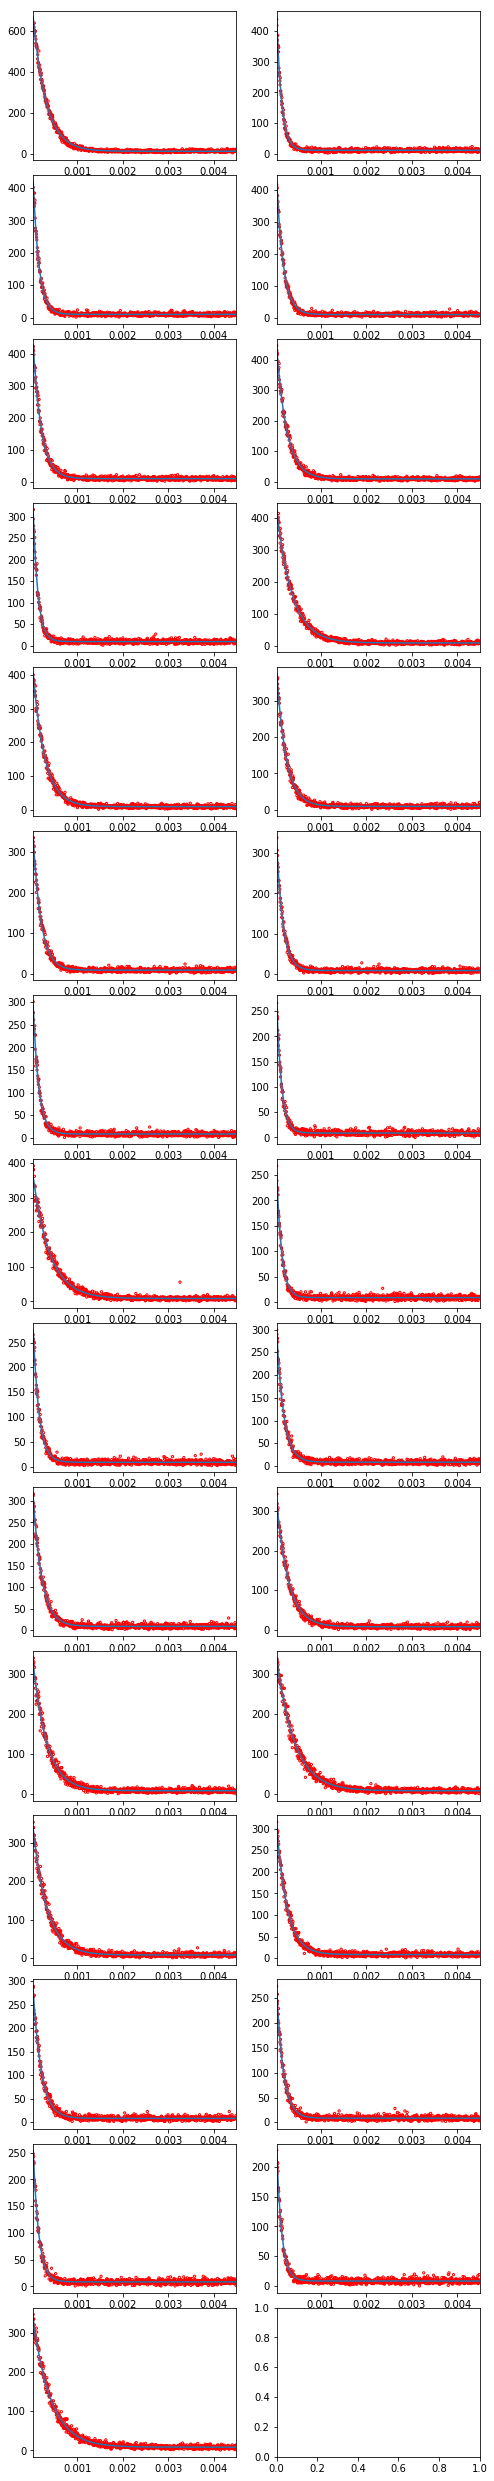

In [150]:
f3 = ""
filelist3 = []
save_arr = []
data_arr = []
#sigma_arr = []
time_arr = []
fit_arr = []
fit_file = "FIT_Coeffs.txt"
err_file = "Fit_Uncert.txt"
summ_file3 = "DAT_Summary.txt"
NoSave = True

def div0( a, b ):
    #""" ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
        c[ ~ np.isfinite( c )] = 1  # -inf inf NaN
    return c

#fit function
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

#fit function
def dexp_func(x, a, b, c, f, g):
    return (a * np.exp(-b * x)) + (f * np.exp(-g * x)) + c


#Find all flies with "".dat" ending
for file in sorted(os.listdir(os.getcwd())):
    if file.endswith(".dat"):
        f3 = str(file)
        filelist3 = np.append(filelist3, f3)

# print(filelist3)
        
#set up plot...
plot_row = int((filelist3.size+plot_col//2)//plot_col)
f, axarr = plt.subplots(plot_row,plot_col, figsize=((plot_col*4),(plot_row*3)), sharex=False)
axarr = axarr.ravel()

#For loop to extract data from each file and build save file list
for idx, item in enumerate(filelist3):

    #build temporary list with data
    temp_arr = []
    temp_arr = np.genfromtxt(item, delimiter = '\t', dtype = 'str',)

    #convert data array to float for fitting - consider changing to import directly as float?!
    temp_arr = temp_arr.astype(np.float)
    time_arr, data_arr = np.hsplit(temp_arr, 2)	
    time_arr = time_arr.flatten()
    data_arr = data_arr.flatten()

    #trim the data array (sometimes the first few data points are rubbish) - currently 15 data points
    #data_arr = np.delete(data_arr, [0,1,2,3,4,5,6,7,8,9,10])

    data_arr = data_arr[time_idx_st:time_idx_en]
    time_arr = time_arr[time_idx_st:time_idx_en]
    #generate x axis (time)

    """time_arr = np.zeros(len(data_arr))
    for i in range(0,len(time_arr)):
        time_arr[i] = i*(time_step*1e-6)

    #sigma = div0(1, data_arr)"""

    #fit data with func()
    popt, pcov = curve_fit(func, time_arr, data_arr, p0=(500,4000,20)) #, sigma=sigma, absolute_sigma=True
    error = [] 
    for i in range(len(popt)):
        try:
            error.append(np.absolute(pcov[i][i])**0.5)
        except:
            error.append( 0.00 )
    perr_curvefit = np.array(error)
    
    axarr[idx].scatter(time_arr, data_arr, s=5, facecolors='none', edgecolors='r')
    axarr[idx].set_xlim([np.amin(time_arr),np.amax(time_arr)])
    axarr[idx].plot(time_arr, func(time_arr,*popt))
    
    
    #if there's no save list yet, then set first set of data to save_arr. Otherwise, stack temp_arr with save_arr
    if NoSave:
        fit_arr = popt
        save_arr = data_arr
        err_arr = perr_curvefit
        NoSave = False
    else:
        save_arr = np.column_stack((save_arr,data_arr))
        err_arr = np.vstack((err_arr,perr_curvefit))
        fit_arr = np.vstack((fit_arr,popt))

#save data to text file.
save_file = open(summ_file3, 'wb')
np.savetxt(save_file, save_arr, delimiter = '\t',fmt="%s")
save_file.close()

#save fit coeffs to file
save_file = open(fit_file, 'wb')
np.savetxt(save_file, fit_arr, delimiter = '\t',fmt="%s")
save_file.close()
#save fit uncerts to file
save_file = open(err_file, 'wb')
np.savetxt(save_file, err_arr, delimiter = '\t',fmt="%s")
save_file.close()

#plot data
f.subplots_adjust(hspace=.1)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.savefig('Data fit.png')


# Analysis

Average Pressure, Torr =
199.3
Average Temperature, K =
258.08


,Run,NO Conc.,Fit
0,1.0,3.121713e+11,3457.692805
1,2.0,1.301577e+15,9108.153060
2,3.0,1.050811e+15,7787.373072
3,4.0,7.946700e+14,6643.013273
4,5.0,5.339015e+14,5487.328098
5,6.0,3.028863e+14,4423.501755
6,7.0,1.417574e+15,9354.305982
7,8.0,1.430572e+13,2922.846898
8,9.0,2.138766e+14,3864.185784
9,10.0,4.015797e+14,4733.964270


slope =
4.572e-12
intercept = 
2.749e+03


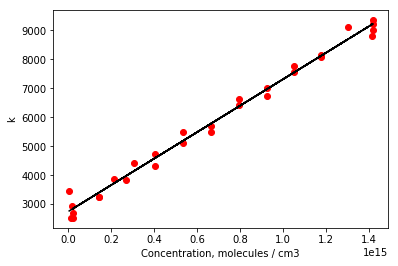

In [11]:
file_name = 'Analysis_030819_200Torr' # Name of the Excel file

data_avg = pd.read_table('AVG_Summary.txt',header=0)
data_avg.drop(data_avg.iloc[:,1:17],inplace = True,axis = 1)
data_avg.drop(data_avg.iloc[:,15:19],inplace = True,axis = 1)
data_avg.drop(data_avg.iloc[:,17:31],inplace = True,axis = 1)

data_avg['NO Concentration'] = data_avg['Actual Flow: NO2']/(data_avg['Actual Flow: HNO3 Bubbler']+
    data_avg['Actual Flow: N2 small 2']+data_avg['Actual Flow: NO2']+data_avg['Actual Flow: N2 Small']+
    data_avg['Actual Flow: N2 Purge']+data_avg['Actual Flow: N2'])*data_avg['Pressure: Chamber Do']/(data_avg['Temperature: Chamber']+273.15)*9.6e18*mix/100

writer = pd.ExcelWriter(file_name + '.xls')
data_avg.to_excel(writer,'Avg_Summary')

avg = r"AVG_Summary.txt"
data_avg = np.genfromtxt(avg, dtype='f8', skip_header=1, usecols=(17,19,21,23,25,27,29,35))
Flow_N2, Flow_N2_Purge, Flow_N2_small, Flow_NO, Flow_HNO3_bubbler, Flow_N2_small_2, Pressure, Temperature=np.hsplit(data_avg,8)
NO_Concentration = Flow_NO/(Flow_HNO3_bubbler+Flow_NO+Flow_N2_small+Flow_N2_Purge+Flow_N2)*Pressure/(Temperature+273.15)*9.66e18*(mix/100)

print('Average Pressure, Torr =') 
print(round(Pressure.mean(),2))
print('Average Temperature, K =') 
print(round(Temperature.mean()+273.15,2))

tfit = r"FIT_Coeffs.txt"
tfit_err = r"Fit_Uncert.txt"
tfit2 = np.genfromtxt(tfit, dtype='f8', usecols=(1))
tfit_err2 = np.genfromtxt(tfit_err, dtype='f8', usecols=(1))
fit = np.transpose(np.hsplit(tfit2,1))

runs = np.transpose([np.array(range(1,fit.size+1))])
table_analysis = np.column_stack((runs,NO_Concentration,fit))
analysis = pd.DataFrame({'Run':table_analysis[:,0],'NO Conc.':table_analysis[:,1],'Fit':table_analysis[:,2]})
display(analysis)

# Make a plot of the data
plt.plot(NO_Concentration,fit, 'ro') 
plt.xlabel('Concentration, molecules / cm3')
plt.ylabel('k')

# Make Linear Fit
x_data = np.array(analysis['NO Conc.'])
y_data = np.array(analysis['Fit'])
(m,b) = polyfit(x_data, y_data, 1)
print('slope =')
print(("{:.3e}".format(m)))
print('intercept = ')
print(("{:.3e}".format(b)))
z = polyval([m,b], NO_Concentration)
f = plot(NO_Concentration, z, 'k--')
plt.savefig('linear_fit.png')
show()

# save to excel Analysis sheet
analysis.to_excel(writer,'Analysis')
writer.save()

